# Machine Learning (SST Patterns -> Eastern US Heatwaves)

### Idea's
- Balance Dataset: Need precursors that exclude multiple years

In [104]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

from skopt import gp_minimize
from skopt.utils import use_named_args, Real, Integer

import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor

import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")

In [236]:
# Helper Functions

def load_heatwave_data():
    # Load Heatwave Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out/heatwave.csv'), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"]) - pd.Timedelta(9, 'h')
    df = df.set_index("date")
    
    # Normalize Heatwave Data
    df = (df - df.mean()) / df.std()
    
    return df

def load_heatwave_ghcn_data():
    # Load Heatwave Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out/heatwave_ghcn.csv'), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"])
    df = df.set_index("date")
    
    # Normalize Heatwave Data
    df = (df - df.mean()) / df.std()
    
    return df

def load_sst_precursor_data(year: int, lag: int):
    df = pd.read_csv(os.path.join(DATA_ROOT, 'patterns', f'{year}-{lag}.csv'))
    df['date'] = pd.DatetimeIndex(df['date']) - pd.Timedelta(9, 'h')
    df = df.set_index('date')
    return df

def load_pna_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'cpc/PNA.txt'), sep='\s+', names=["year", "month", "series"])
    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df["series"].values, index=df_date, columns=["series"])
    return df.reindex(date_range).interpolate()

def load_nao_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'cpc/NAO.txt'), sep='\s+', names=["year", "month", "series"])
    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df["series"].values, index=df_date, columns=["series"])
    return df.reindex(date_range).interpolate()

def load_enso_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'cpc/ENSO.txt'), sep='\s+', header=0, names=[
        "year", "month", "NINO1+2", "NINO1+2_ANOM", "NINO3", "NINO3_ANOM", "NINO4", "NINO4_ANOM", "NINO3.4", "NINO3.4_ANOM"
    ])

    df_date = df[["year", "month"]]
    df_date.insert(2, "day", 1)
    df_date = pd.to_datetime(df_date)

    date_range = pd.date_range(df_date[0], df_date[len(df_date)-1])

    df = pd.DataFrame(df.iloc[:, 2:].values, index=df_date, columns=df.columns[2:])
    return df.reindex(date_range).interpolate()

def plot_heatwave(heatwave: pd.Series, year: int, fit: pd.Series=None):
    # Working with Normalized Data
    heatwave_std = 1
    
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot Heatwave
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(heatwave[str(year)], c="black", label="T95")
    plt.axhline(heatwave_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(heatwave[str(year)].index, heatwave_std, heatwave[str(year)],
                     where=heatwave[str(year)] > heatwave_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")
    
    # Plot Fit if Provided
    if fit is not None:
        plt.plot(fit[str(year)])

    plt.xlabel("Date")
    plt.ylabel("Heatwave (STD)")
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()
    
def plot_roc(y_true: pd.DataFrame, y_predict: pd.DataFrame, threshold: float):
    # Make Square Plot
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
    fpr, tpr, thr = roc_curve(y_true > threshold, y_predict)
    auc = roc_auc_score(heatwave > threshold, y_predict)

    plt.title(f"ROC Curve - AUC: {auc:5.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")
    plt.show()

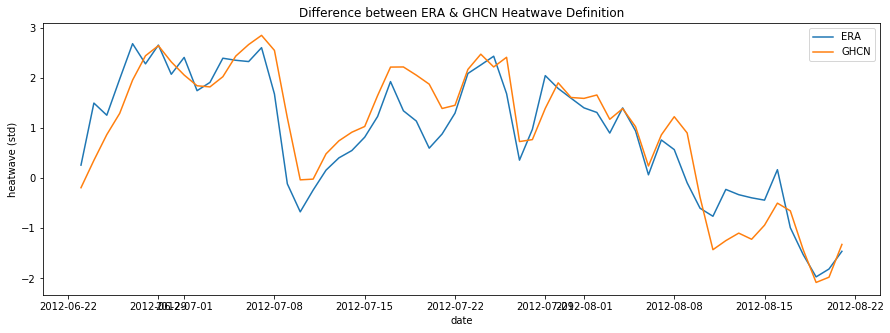

In [288]:
plot_year = 2012
plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Difference between ERA & GHCN Heatwave Definition")
plt.plot(load_heatwave_data()[str(plot_year)], label="ERA")
plt.plot(load_heatwave_ghcn_data()[str(plot_year)], label="GHCN")
plt.xlabel("date")
plt.ylabel("heatwave (std)")
plt.legend()
plt.show()

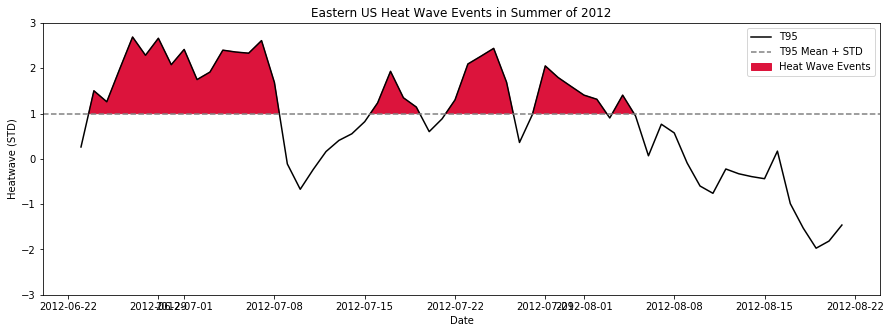

In [299]:
# Load Heatwave Data
heatwave = load_heatwave_data()
heatwave_ghcn = load_heatwave_ghcn_data()

# Heatwave Threshold (Heatwave.mean + Heatwave.std = 1 (for normalized data))
heatwave_threshold = 1

YEARS = np.unique(heatwave.index.year)

plot_heatwave(heatwave['series'], 2012)

In [297]:
# Feature Generation and Machine Learning Training

def create_features(heatwave: pd.DataFrame, precursor: pd.DataFrame, lag: int):
    features = pd.DataFrame(index=heatwave.index)
    
    # Heatwave Timestamp minus 'lag' Days
    index = (heatwave.index - pd.Timedelta(lag, 'D'))
    
#     # Pacific North America Pattern Index
#     features["pna"] = load_pna_data().loc[index].values
    
#     # North Atlantic Oscilation Index
#     features["nao"] = load_nao_data().loc[index].values
    
#     # El Nino Southern Oscilation Index
#     enso = load_enso_data()
#     for column in enso.columns:
#         features[column] = enso[column][index].values
    
    # Sea Surface Temperature Patterns (Sem)
    for column in precursor.columns:
        if 'average' in column:
            features[column] = precursor[column][index].values
#             features[f"{column}-mean"] = precursor[column].rolling(4).mean()[index].values
        
    return features
    
def train(regressor, features: pd.DataFrame, labels: pd.DataFrame, test_year: int):
    
    # Split Data in Test/Train Sets
    train_x = pd.concat([features[str(year)] for year in YEARS if year != test_year])
    test_x = features[str(test_year)]
    
    train_y = pd.concat([labels[str(year)] for year in YEARS if year != test_year])
    test_y = labels[str(test_year)]
    
    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel())
    
    # Predict Heatwaves for Test Year
    prediction = pd.DataFrame(regressor.predict(test_x).reshape(-1, 1), index=test_y.index)
    
    return test_y, prediction

def train_year(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int, test_year: int):
    
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)
    
    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)
    
    # Train Regressor with Features and Heatwave Data
    test_y, prediction = train(regressor, features, heatwave, test_year)
    
    return prediction

def train_all(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int):
    
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_year, regressor, heatwave, precursor_lag, lag, test_year) for test_year in YEARS]
        
        # Obtain Results
        results = [future.result() for future in futures]
        
        # Wrap into Predictions DataFrame
        predictions = pd.DataFrame(np.concatenate(results), index=heatwave.index)
        
    return predictions

def train_optimize(heatwave: pd.DataFrame, heatwave_threshold: float, precursor_lag: int, lag: int, iterations: int):
    hyperparameter_space = [
        Integer(100, 250, name="n_estimators"),
        Integer(2, 6, name="max_depth"),
        Real(1E-3, 0.1, name="learning_rate")]
    
    def _train_optimize_callback(result):
        print(f"{len(result.x_iters):3d}: {-result.func_vals[-1]:5.5f} <- {str(result.x_iters[-1]):30} | max: {-result.fun:5.5f} <- {str(result.x):30}")
    
    @use_named_args(hyperparameter_space)
    def _train_optimize(**kwargs):
        n_estimators = kwargs['n_estimators']
        max_depth = kwargs['max_depth']
        learning_rate = kwargs['learning_rate']
        
        regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        predictions = train_all(regressor, heatwave, precursor_lag, lag)
        score = roc_auc_score(heatwave > heatwave_threshold, predictions)
        
        return -score
    
    result = gp_minimize(_train_optimize, hyperparameter_space, n_calls=iterations, callback=_train_optimize_callback)
    
    return {item.name: value for item, value in zip(hyperparameter_space, result.x)}

def feature_importances(regressor, heatwave, precursor_lag, lag, test_year):
    
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)
    
    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)
    
    # Train Regressor with Features and Heatwave Data
    test_y, prediction = train(regressor, features, heatwave, test_year)
    
    order = np.argsort(regressor.feature_importances_)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.title(f"Feature Importances for {regressor.__class__.__name__} @ test year {test_year}")
    plt.barh(np.arange(len(features.columns)), regressor.feature_importances_[order], tick_label=features.columns[order])
    plt.show()
    
def train_deviance_year(regressor, heatwave, precursor_lag, lag, test_year):
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)

    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)

    # Train Regressor with Features and Heatwave Data
    # Split Data in Test/Train Sets
    train_x = pd.concat([features[str(year)] for year in YEARS if year != test_year])
    test_x = features[str(test_year)]

    train_y = pd.concat([heatwave[str(year)] for year in YEARS if year != test_year])
    test_y = heatwave[str(test_year)]

    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel())
    
    # Return Train Score & Test Score (MSE)
    return regressor.train_score_, [mean_squared_error(p, test_y) for p in regressor.staged_predict(test_x)]
    
def train_deviance(regressor, heatwave, precursor_lag, lag):
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_deviance_year, regressor, heatwave, precursor_lag, lag, test_year) for test_year in YEARS]
        
        train_scores = []
        test_scores = []
        
        # Obtain Results
        for train_mse, test_mse in [future.result() for future in futures]:
            train_scores.append(train_mse)
            test_scores.append(test_mse)
            
    train_scores = np.mean(train_scores, 0)
    test_scores = np.mean(test_scores, 0)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.title(f"Gradient Boosting Regressor Performance over Iterations\n(Optimal Iterations: {np.argmin(test_scores) + 1}, Min MSE: {np.min(test_scores)})")
    plt.plot(train_scores, label="Training Set Deviance")
    plt.plot(test_scores, label="Test Set Deviance")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance (MSE)")
    plt.legend()
    plt.show()

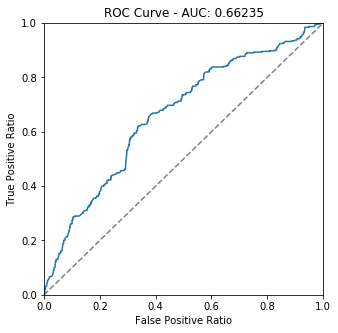

In [311]:
regressor = GradientBoostingRegressor(n_estimators=125, max_depth=3, learning_rate=0.01)
predictions = train_all(regressor, heatwave, precursor_lag=0, lag=50)
plot_roc(heatwave, predictions, heatwave_threshold)

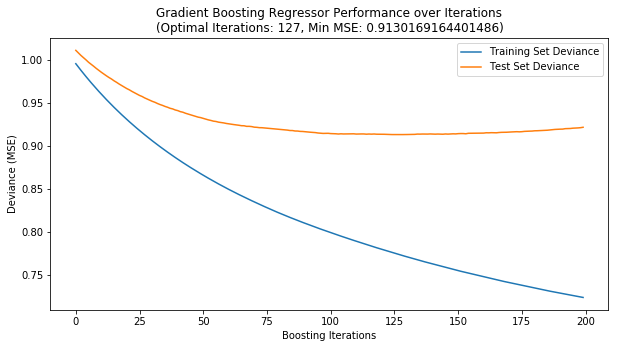

In [306]:
# Optimize Gradient Boosting Regressor by Looking at Train/Test Deviance at all Boosting Iterations
regressor = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.01)
train_deviance(regressor, heatwave, precursor_lag=0, lag=50)

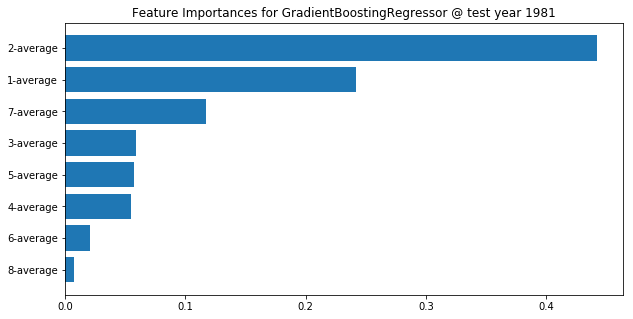

In [307]:
feature_importances(regressor, heatwave, precursor_lag=0, lag=50, test_year=1981)

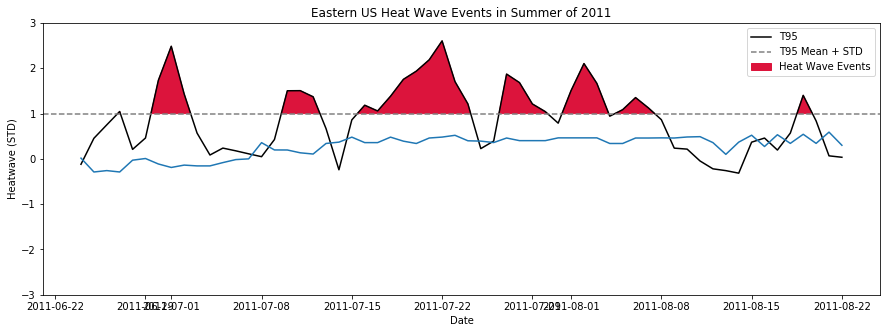

In [284]:
plot_heatwave(heatwave=heatwave['series'], fit=predictions, year=2011)